# Building a Neural Network From Scratch

## Introduction

In this exercise you are asked to create a simple multilayer perceptron (MLP) neural network from scratch using only the Numpy package for matrix-vector operations. In order to train the network on several datasets, you will need to implement the back-propagation algorithm with gradient descent. Before getting started, let's review the notation we will use and recall the stochastic gradient descent algorithm.

### Notation

We will consider simple feed-forward networks that can be described by the following recursive relationship,

$$
\begin{align}
&z^l = a^{l-1} W^l + b^l,\\
&a^l = \sigma^l(z^l),
\end{align}
$$

where $a^l$ is the output (activation) of layer $l$ which is a nonlinear function $\sigma^l$ of a linear transformation of the previous layer's output. The linear transformation is performed using the weight matrix $W^l$ and bias vector $b^l$ associated with the layer $l$. We will denote the last layer in the network with a capital $L$ superscript. The recursion is stopped by setting $a^0 = x$, where $x$ is the input vector to our network. Note that in the recursive expressions above, we implicitly assume that our input/output vectors are row vectors. The reason for this will be evident later.

Taking this notation into account, we see that a network with $L-1$ hidden layers is fully expressed by its $L$ weight matrices, bias vectors, and activation functions. We can denote the set of trainable parameters in our network by $\theta = \{ W^1, \dots, W^L, b^1, \dots, b^L \}$.

In this exercise, we are only concerned with supervised learning tasks. Recall that in supervised learning, we have a dataset represented by a list of $(x, y)$ pairs where $x$ is the input to our model and $y$ is the desired output.

- For regression problems where we want to fit a function $y = f(x)$, $x$ is the independent variable vector, and $y$ is the function value.
- In classification problems, $x$ will correspond to a set of attributes and $y$ the corresponding label.

The goal of supervised learning is to "train" our network by adjusting its parameters in order to minimize a cost function over the entire training set,

$$
\min_\theta \mathcal{L} = \min_\theta \frac{1}{N} \sum_{p=1}^N \ell_p 
$$

where $\ell_p$ is just a short-hand notation for $\ell_p = \ell(a^L(x_p), y_p)$ and $\ell(\hat{y}, y)$ denotes the particular form of the loss function being considered. In this exercise, we will use 2 different loss functions:

1. Quadratic Loss: $\ell(\hat{y}, y) = \|\hat{y} - y\|^2 / 2$
2. Cross-entropy Loss: $\ell(\hat{y}, y) = -\sum_j[ y_j \ln\hat{y}_j + (1-y_j)\ln(1-\hat{y}_j)]$

## Step 1: Build an untrainable network

Understanding (and implementing) the back-propagation algorithm can seem a little daunting at first. Therefore, let's start by building out the functions we need just to create a network that cannot be trained. First load the libraries. _You should only have to do this once._

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Exercise 1: Implement the activation functions.

1. The easiest activation we can implement is the identity function which simply returns the input as itself.  Implement this below in the class template `Identity`. The `prime` function should implement the derivative of the activation.
2. The threshold activation function takes an input and returns 1 if the input is positive, otherwise 0. Implement the `Threshold` class below. (hint: use the `np.where` function)
3. Recall that the sigmoid function is given as $\sigma(x) = 1 / (1 + \exp(-x))$. Derive the derivative of $\sigma(x)$ and show that it can be represented as $\sigma'(x) = \sigma(x) [1 - \sigma(x)]$
4. Implement the `Sigmoid` class below.

In [2]:
# Define classes of activation functions
class Identity:

    @staticmethod
    def __call__(x):
        return x

    @staticmethod
    def prime(x):
        return np.ones(x.shape)

    
class Threshold:

    @staticmethod
    def __call__(x):
        return np.where(x>0, 1, 0)
    
    @staticmethod
    def prime(x):
        return np.zeros(x.shape)

    
class Sigmoid:

    @staticmethod
    def __call__(x):
        return 1/(1+np.exp(-x))

    @staticmethod
    def prime(x):
        s = Sigmoid()
        return s(x)*(1-s(x))


class ReLU:

    @staticmethod
    def __call__(x):
        return x * (x>0)

    @staticmethod
    def prime(x):
        return 1 * (x>0)  

5. Plot the activation functions and their derivative on the domain [-5, 5].

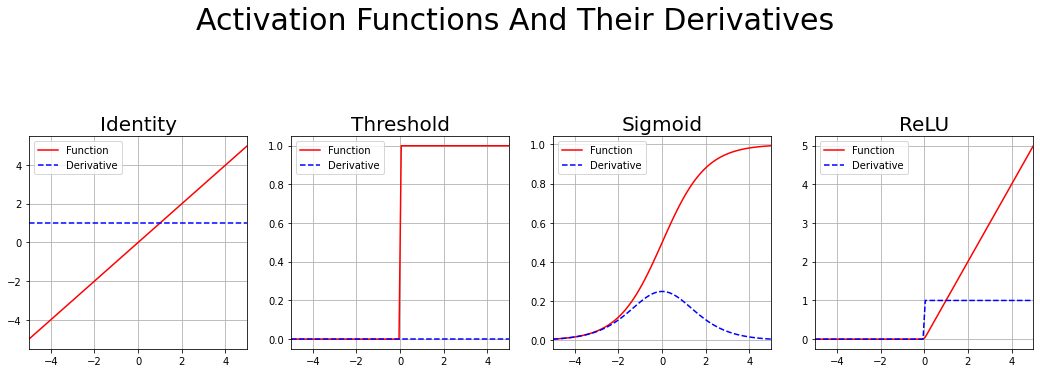

In [3]:
# Plot all activation functions and their derivatives
x = np.linspace(-5, 5, 100)
plot_activations = [Identity(), Threshold(), Sigmoid(), ReLU()]
plot_titles = ["Identity", "Threshold", "Sigmoid", "ReLU"]
plot_size = len(plot_activations)

fig = plt.figure(figsize=(18,18))
fig.suptitle("Activation Functions And Their Derivatives", fontsize=30)

for i, y in enumerate(plot_activations):
    fig.add_subplot(plot_size, plot_size, i+1)
    plt.plot(x, y(x), 'r-', label='Function')
    plt.plot(x, y.prime(x), 'b--', label='Derivative')
    plt.xlim(x[0], x[-1])
    plt.grid()
    plt.title(plot_titles[i], fontsize=20)
    plt.legend()

plt.show()

During this exercise, we will build on the following python class called `Network` which will represent our neural net. The `Network` class will keep track of the weights, biases, and activations needed to evaluate and train our model. The following exercises will guide you through building up the class from the skeleton below.

In [4]:
class Network:
    """A simple implementation of a feed-forward artificial neural network.
    
    Work on this class throughout the entire exercise, re-running this cell after each update.
    """
    def __init__(self, sizes, activations):
        """Construct a network given a list of the number of neurons in each layer and 
        a list of activations which will be applied to each layer.
        
        :param sizes: A list of integers representing the number of nodes in each layer, 
        including the input and output layers.
        :param activations: A list of callable objects representing the activation functions.
        Its size should be one less than sizes.
        """
        # Check for dimension compatibility
        if len(sizes) != len(activations) + 1:
            raise ValueError("Dimensions of 'sizes' and 'activations' are not equal.")
        
        # Initialize weights
        self.weights = []
        for ind, val in enumerate(sizes):
            if ind + 1 != len(sizes):
                tmp_array = np.random.standard_normal((val,sizes[ind+1]))
                self.weights.append(tmp_array)

        # Initialize biases
        self.biases = []
        for ind, _ in enumerate(sizes):
            if ind + 1 != len(sizes):
                tmp_array = np.random.standard_normal((1,sizes[ind+1]))
                self.biases.append(tmp_array)

        # Initialize activation functions
        self.activations = activations
        
    
    def num_params(self):
        """Returns the total number of trainable parameters in this network."""
        return np.sum([arr.size for arr in self.weights]) + np.sum([arr.size for arr in self.biases])
    
    
    def feed_forward(self, x):
        """Evaluates the network for the given input and returns the result.
        
        :param x: A numpy 2D-array where the columns represent input variables
        and rows represent independent samples.
        """
        z = []
        a = []
        output = []
        z_p = []
        a_p = []
        a_prev = 0

        # Feed-forward loop
        for i in range(x.shape[0]):
            for l, (weight, bias, activation) in enumerate(zip(self.weights, self.biases, self.activations)):
                if l == 0:
                    a_prev = x[i,:].reshape(1,x.shape[1])
                else:
                    a_prev = a_p[l-1]
                
                z_l = np.matmul(a_prev, weight) + bias
                activate = activation
                a_l = activate(z_l)

                z_p.append(z_l)
                a_p.append(a_l)

            z.append(z_p)
            a.append(a_p)
            output.append(a_p[-1])
            a_p_len = a_p[-1].shape[-1]

            z_p = []
            a_p = []

        return np.array(output).reshape(x.shape[0], a_p_len), z, a
        
    
    def backprop(self, x, y, cost):
        """Compute gradients of cost function w.r.t network parameters for a training point."""
        z_p = []
        a_p = []
        a_prev = 0
        
        # Reshape if needed
        if y.ndim == 0:
            y = y.reshape(1, 1)
        
        # Feed-forward loop for one point
        for l, (weight, bias, activation) in enumerate(zip(self.weights, self.biases, self.activations)):
            if l == 0:
                a_prev = x[:].reshape(1,x.shape[0])
            else:
                a_prev = a_p[l-1]

            z_l = np.matmul(a_prev, weight) + bias
            activate = activation
            a_l = activate(z_l)

            z_p.append(z_l)
            a_p.append(a_l)
        
        delta = []
        cost_fun = cost
        activate = self.activations[-1]

        # Calculate delta for last layer
        delta_L = cost_fun.derivative(a_p[-1], y) * activate.prime(z_p[-1])
        delta.append(delta_L)

        # Back-propagation loop
        for l in range(len(self.weights)-1, 0, -1):
            delta_next = delta[-1]
            
            activate = self.activations[l-1]
            delta_l = np.matmul(delta_next, self.weights[l].T) * activate.prime(z_p[l-1])

            delta.append(delta_l)

        delta = list(reversed(delta))
        weight_grad = []
        bias_grad = []

        # Calculate parameter gradients
        for l in range(len(a_p)):
            if l == 0:
                a_prev = x[:].reshape(1,x.shape[0])
            else:
                a_prev = a_p[l-1]

            weight_grad_l = a_prev.T * delta[l]
            bias_grad_l = delta[l]

            weight_grad.append(weight_grad_l)
            bias_grad.append(bias_grad_l)

        return weight_grad, bias_grad


    def update_step(self, training_data, cost, learning_rate):
        """Compute the average parameter gradients over the whole training set and do a GD step.
        
        :param training_data: An (x, y) tuple containing the training data.
        :param cost: A callable object with signature cost(y_pred, y) for computing the cost of a single
        training example.
        :param learning_rate: The learning rate to use in the GD step.
        """
        x, y = training_data

        # Reshape if needed
        if x.ndim == 1:
            x = x.reshape(1, x.shape[0])

        # Back-propagate for each point
        for i in range(x.shape[0]):
            back_prop = self.backprop(x[i], y[i], cost)
            if i == 0:
                weight_sum = back_prop[0]
                bias_sum = back_prop[1]
            else:
                weight_sum = [sum(val) for val in zip(weight_sum, back_prop[0])]
                bias_sum = [sum(val) for val in zip(bias_sum, back_prop[1])]

        # Caclulate parameter updates
        weight_update = [learning_rate*val/3 for val in weight_sum]
        bias_update = [learning_rate*val/3 for val in bias_sum]

        # Update parameters
        self.weights = [val1-val2 for val1, val2 in zip(self.weights, weight_update)]
        self.biases = [val1-val2 for val1, val2 in zip(self.biases, bias_update)]
    
    
    def train(self, training_data, cost, learning_rate, epochs):
        """Train this network on the training data
        
        :param training_data: An (x, y) tuple containing the training data.
        :param cost: A callable object with signature cost(y_pred, y) for computing the cost of a single
        training example.
        :param learning_rate: The learning rate to use in the GD step.
        :param epochs: The number of epochs to train with.
        """
        x, y = training_data

        # Reshape if needed
        if x.ndim == 1:
            x = x.reshape(1, x.shape[0])
        
        # Train network
        for i in range(epochs):
            # Update step
            self.update_step(training_data, cost, learning_rate)
            
            # Compute loss
            loss = sum(cost(self.feed_forward(x)[0], y)) / x.shape[0]
            print(f"Epoch: {i}, Loss: {loss}.")

### Exercise 2: First draft of the Network class

1. From the recursion formulas above, write down the shapes of the weight matrices and bias vectors, given the number of neurons in each layer.
2. Implement the init `__init__` function in `Network` above. Construct a list of weight matrices and bias vectors which are randomly initialized with normal distributions (see `np.random.randn`).
2. Implement the `num_params` function in `Network` above. Use your knowledge of the shapes of the weights and biases.
3. Implement the `feed_forward` function in `Network` above. Use the recurrance relations discussed in the Notation section.

### Exercise 3: Test feed-forward Network initialization

1. Create a network with 2 hidden layers of 4 nodes that takes 4 inputs and has 1 output. (Use any activation)

In [5]:
# Instantiate basic network
net = Network([4, 4, 4, 1], [Sigmoid(), Identity(), Identity()])

2. Compute by hand the number of parameters this network should have. (45)
3. Check that `num_params` provides the same value.

In [6]:
# Calculate number of trainable parameters
net.num_params()

45

4. Print the weights and biases of the network and confirm they are intialized correctly (shape and values).

In [7]:
# Print parameters
print(f"Weight matrix: {net.weights[0]}")
print(f"Bias vector: {net.biases[0]}")

# Print shapes
print(f"Weight matrices shape: {[val.shape for val in net.weights]}")
print(f"Bias vectors shape: {[val.shape for val in net.biases]}")

Weight matrix: [[ 2.01146479  2.48046731  0.51974348  0.23079292]
 [ 1.17845022 -0.83268864 -0.32931896 -0.22362349]
 [-0.99980805  0.77976243 -1.05975768  0.05318434]
 [ 0.38906439 -0.33849242  1.04085904  0.11768428]]
Bias vector: [[ 0.24470774 -0.54563437  0.06323733  0.59353802]]
Weight matrices shape: [(4, 4), (4, 4), (4, 1)]
Bias vectors shape: [(1, 4), (1, 4), (1, 1)]


### Exercise 4: Build logic gates

Below is a table of logical functions (logic gates). Each function takes two values (A and B) representing True (1) or False (0) propositions and returns a True or False value.

| A | B | AND | OR | XOR | NAND |
|---|---|-----|----|-----|------|
| 0 | 0 | 0   | 0  | 0   | 1    |
| 0 | 1 | 0   | 1  | 1   | 1    |
| 1 | 0 | 0   | 1  | 1   | 1    |
| 1 | 1 | 1   | 1  | 0   | 0    |

Interestingly, [it is possible to create any boolean function of any size through a combination of NAND gates](https://en.wikipedia.org/wiki/NAND_gate)! Thus, if we can create a network which reproduces the logic behind a NAND-gate, it is possible to represent any logical function (and by extension any mathematical function) by combining such a network into ever more complex networks. This is one version of a universal approximation theorem for ANNs.

**Task:** build the AND, OR, and NAND logic gates above using the simple network below by modifying its weights and biases directly. I have provided the `logic_gate` function to help test your networks.

In [8]:
def logic_gate(network):
    """Helper function for testing our network as a logic gate."""
    return network.feed_forward(
        np.asarray(
            [[0, 0],
            [0, 1],
            [1, 0],
            [1, 1]]
        )
    )[0]


# Create simple "logic gate" network
network = Network([2, 1], [Threshold()])

# Modify weights and biases to create logic gates
# AND gate
network.weights[0] = np.array([1, 1])
network.biases[0] = np.array([-1])
print('AND(A,B) = \n', logic_gate(network))

# OR gate
network.weights[0] = np.array([2, 2])
network.biases[0] = np.array([-1]) 
print('OR(A,B) = \n', logic_gate(network))

# NAND gate
network.weights[0] = np.array([-1, -1]) 
network.biases[0] = np.array([2]) 
print('NAND(A,B) = \n', logic_gate(network))

AND(A,B) = 
 [[0]
 [0]
 [0]
 [1]]
OR(A,B) = 
 [[0]
 [1]
 [1]
 [1]]
NAND(A,B) = 
 [[1]
 [1]
 [1]
 [0]]


## Step 2: Training the network

While interesting, the `Network` class above is pretty useless as it stands since there is no way to learn a function we don't already know. In this step, we will add the ability to train our network on a dataset using the gradient descent and back-propagation algorithms. Let's review both of these algorithms now.

### (Stochastic) Gradient Descent

Recall from the beginning of the exercise that we want to train the network parameters by minimizing a given loss function over an entire dataset. One method of doing this is using the gradient descent (GD) algorithm which you have already seen this in the lecture portion of the class, thus I will just provide the update rule here.

$$
\theta = \theta - \eta \nabla_\theta \mathcal{L},
$$

where $\eta$ is the learning rate. The update rule above is called GD because direction of change in the network parameters follow the opposite of the parameters' gradient in the loss function. You can think of this like a ball rolling down a hill to find the minimum of the topology. Only in this case, the ball is massless because it has no momentum. When this update rule is applied to a random subset of the total dataset, it is called stochastic gradient descent (SGD). SGD is far more efficient than GD when the batch size is large enough to approximate the true gradients while being significantly smaller than the full dataset. Running over the entire dataset with SGD once is called an epoch of training.

### Back-Propagation

From the GD update rule above, it is clear we will need to compute the gradients of the network parameters with respect to the cost function. This is exactly what back-propagation does, and thus is a crucial component to almost all neural network learning algorithms. In the next exercise, we will derive the 4 equations in back-propagation.  You will need knowledge of the [chain rule for differentiation](https://en.wikipedia.org/wiki/Chain_rule) if you are not already familiar with this.

### Exercise 5: Derive backprop formulas

Before we start, it is convenient to define the following variable,

$$
\delta^l \equiv \frac{\partial \ell_p}{\partial z^l},
$$

Thus $\delta^l$ is the gradient of the loss function for a point $p$ with respect to the input to the activation function for the layer $l$ in our network.

1. What is the shape of $\delta^L$? (same as output)
2. Show that $\delta^L = \nabla_{a^L} \ell_p  \odot {\sigma'}^L ( z^L )$. Hint: apply the chain rule to the definition of $\delta^L$.
3. Show that for $l < L$, $\delta^l = [\delta^{l+1} (W^{l+1})^T ] \odot {\sigma'}^l ( z^l )$.  Hint: try computing $\delta^{L-1}$ and compare to $\delta^L$.
4. Show that $\nabla_{W^l}\ell_p = (a^{l-1})^T \delta^l$. Hint: use definition of $z^l$.
5. Show that $\nabla_{b^l}\ell_p = \delta^l$.

Note that these four formulas allow us to compute the gradient of the loss function for a single training point with respect to the parameters of our network. Looking at the equations more closely, you should see a possible algorithm form.

1. Compute the values of $z^l$ and $a^l$ for $l = {1, \dots, L}$ by forward propagation through the network. Recall $a^0 = x_p$.
2. Use the equation in Exercise 5.2 above to compute $\delta^L$.  
3. Back-propagate in the reverse direction using the equation in Exercise 5.3 to get all the other $\delta^l$ values.
4. Compute the parameter gradients using the equations in Exercises 5.4 and 5.5.

Note that this will yield the gradients for a single training point. The gradients for the total loss function can easily be computed by

$$
\nabla_\theta \mathcal{L} = \frac{1}{N} \sum_{p=1}^N \nabla_\theta \ell_p.
$$

Of course, the exact form of $\nabla_\theta \ell_p$ will depend on the choice of $\ell$.

### Exercise 6: Implement the training algorithm

Before we can implement the training algorithm, we need to define a cost function. For now, let's create a class representing the quadratic cost which was given in the introduction.

1. Show that the derivative of the quadratic cost is $\nabla_{\hat{y}} \ell(\hat{y}, y) = \hat{y} - y$.
2. Implement the quadratic cost function below.

In [9]:
# Define quadratic loss function class
class QuadraticCost:

    @staticmethod
    def __call__(y_pred, y):
        """Computes the quadratic cost function."""
        return np.asarray([(val1-val2)**2/2 for val1, val2 in zip(y_pred, y)])
    
    @staticmethod
    def derivative(y_pred, y):
        """Computes the derivative of the quadratic cost function."""
        return np.asarray([val1-val2 for val1, val2 in zip(y_pred, y)])

With this cost defined, let's implement three remaining functions in `Network` that will allow us to train our models. The first is the `backprop` method which takes a single training sample $x, y$ and a cost function object like the one above, and computes the gradient of the cost function using the backpropagation algorithm.

3. Implement the `backprop` funtion in the `Network` class.

Next, implement a single epoch of training by averaging the gradients over the whole dataset (calling `backprop` on each data point) and using the GD update rule to update the weights and biases.

4. Implement the `update_step` function in the `Network` class.

The `update_step` method is used by the `train` method successively in a loop as you can see in the `Network` class implementation above. Assuming you have correctly implemented the `backprop` and `update_step` functions correctly, you should now be able to train the network on real training data.

### Exercise 7: Test training on simple regression problem.

Run the following code to test the network. If all is correct, you should see the total loss dropping and the network will learn the sine function.  

1. Play with different hyperparameters of the network and training such as the number of layers, number of nodes per layer, training rate, and number of training samples. Can you improve on the training performance?

Epoch: 0, Loss: [1.39065937].
Epoch: 1, Loss: [0.8550996].
Epoch: 2, Loss: [0.42414435].
Epoch: 3, Loss: [0.30355822].
Epoch: 4, Loss: [0.2420983].
Epoch: 5, Loss: [0.21023571].
Epoch: 6, Loss: [0.18931171].
Epoch: 7, Loss: [0.17429508].
Epoch: 8, Loss: [0.16292675].
Epoch: 9, Loss: [0.15404961].
Epoch: 10, Loss: [0.14693642].
Epoch: 11, Loss: [0.14109302].
Epoch: 12, Loss: [0.13616964].
Epoch: 13, Loss: [0.13191444].
Epoch: 14, Loss: [0.12814398].
Epoch: 15, Loss: [0.12472364].
Epoch: 16, Loss: [0.12155406].
Epoch: 17, Loss: [0.11856156].
Epoch: 18, Loss: [0.1156914].
Epoch: 19, Loss: [0.11290291].
Epoch: 20, Loss: [0.11016598].
Epoch: 21, Loss: [0.10745855].
Epoch: 22, Loss: [0.10476474].
Epoch: 23, Loss: [0.1020735].
Epoch: 24, Loss: [0.09937762].
Epoch: 25, Loss: [0.09667297].
Epoch: 26, Loss: [0.09395799].
Epoch: 27, Loss: [0.09123324].
Epoch: 28, Loss: [0.08850107].
Epoch: 29, Loss: [0.08576535].
Epoch: 30, Loss: [0.08303127].
Epoch: 31, Loss: [0.08030506].
Epoch: 32, Loss: [0.07

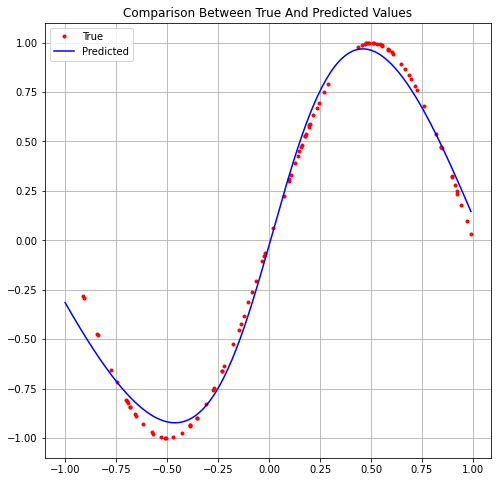

In [14]:
# Define argument and function
x = np.random.uniform(-1, 1, (100, 1))
y = np.sin(np.pi*x)

# Instantiate network and train it
network = Network([1, 100, 50, 1], [Sigmoid(), Sigmoid(), Identity()])
network.train((x, y), QuadraticCost(), 0.001, 1000)

# Make feed-forward predictions
x_pred = np.arange(-1, 1, 0.01).reshape(200, 1)
y_pred = network.feed_forward(x_pred)[0].reshape(200, 1)

# Plot results
fig = plt.figure(figsize=(8,8))
plt.plot(x, y, 'r.', label='True')
plt.plot(x_pred, y_pred, 'b-', label='Predicted')
plt.grid()
plt.title("Comparison Between True And Predicted Values")
plt.legend(loc='upper left')
plt.show()

<font color='#4863A0'>As can be seen, such a simple neural network with two hidden layers and sufficiently small learning rate parameter predicts the sine function quite well.</font>

## Step 3: Hand-written digit classification

Let's test our model on a more sophisticated dataset, namely the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). This dataset includes 70,000 images of hand-written digits 28x28 pixels (=784), split into a training set of 60,000 images and a test set of 10,000 images. Each image is labeled with a digit from 0 to 9.  

### Exercise 8: Download the MNIST dataset

1. Just run the following cell to download the MNIST database and prepare it.

In [12]:
import tensorflow.keras.datasets.mnist as mnist

In [13]:
# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

# Resape X_train and X_test to 2D
X_train = X_train.reshape(-1, X_train.shape[1]**2)
X_test = X_train.reshape(-1, X_test.shape[1]**2)

2. Next check that the shapes of the training and test data are what you expect.

In [14]:
# Inspect images
print(f"X_train shape: {X_train.shape}.", f"y_train shape: {y_train.shape}.", sep='\n')

X_train shape: (60000, 784).
y_train shape: (60000,).


3. Get a feel for the dataset by viewing some images.

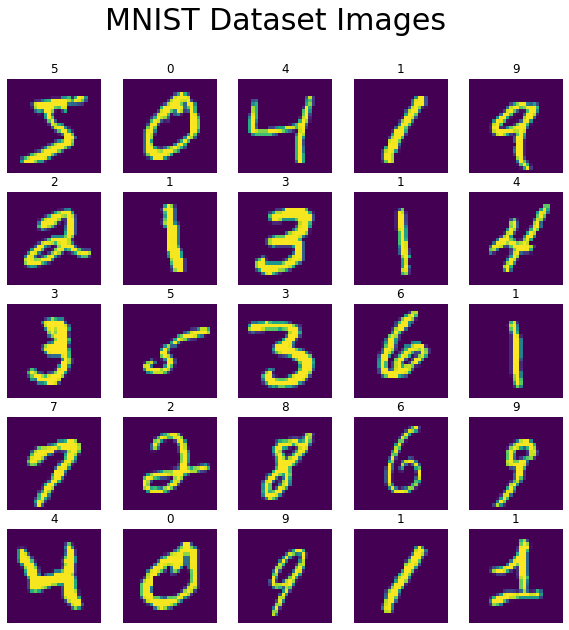

In [15]:
# Plot images
fig = plt.figure(figsize=(10,10))
fig.suptitle('MNIST Dataset Images', fontsize=30)
plt.set_cmap('viridis')

for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(X_train[i,:].reshape(28, 28))
    plt.axis('off')
    plt.title(y_train[i])

plt.show()

### Exercise 9: Create a one-hot encoding of the labels

`y_train` and `y_test` currently contain the digits 0-9, which is not suited for training as we want to perform a 10-class classification training on our network. To fix this, we need to perform a so-called **one-hot encoding** on the labels which convert each digit into a vector of length 10 full of zeros, except the element corresponding to the digit which should be 1.  For example, if our label is 3, then the corresponding one-hot encoding is [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

1. Convert the `y_train` and `y_test` vectors into one-hot encodings.

In [41]:
# Define alphabet
alphabet = np.unique(y_train)

# One-hot encode target data
y_train_oh = np.where([alphabet==val for val in y_train], 1, 0)
y_test_oh = np.where([alphabet==val for val in y_test], 1, 0)

### Exercise 10: Train a network to recognize digits

1. Implement the cross-entropy loss function below.

In [106]:
# Define cross-entropy loss function class
class CrossEntropy:

    @staticmethod
    def __call__(y_pred, y):
        return -np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred), axis=1)
    
    @staticmethod
    def derivative(y_pred, y):
        return -np.sum(y/y_pred - (1-y)/(1-y_pred), axis=1)

2. Train a model with 1 hidden layers of 30 nodes each, using sigmoidal activations and a cross-entropy loss.

In [107]:
# Instantiate network
img_net = Network([784, 30, 10], [Sigmoid(), Identity()])

In [108]:
# Train network
img_net.train((X_train, y_train_oh), CrossEntropy(), 0.5, 30)

C:\Users\Ivan\AppData\Local\Temp/ipykernel_2272/4203956819.py:28: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
C:\Users\Ivan\AppData\Local\Temp/ipykernel_2272/34500065.py:5: RuntimeWarning: invalid value encountered in log
  return -np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred), axis=1)


Epoch: 0, Loss: nan.
Epoch: 1, Loss: nan.


KeyboardInterrupt: 

3. Compute the accuracy of the model on the test data and compare a few predictions to their images.

In [ ]:
# TODO

## Extra

At this point you have a fully functioning neural network model which can be used in real machine-learning problems.  There are many things which you could add at this point to make the model more effective. Consider playing with some of the following:

- Adding weight regularization
- Using different activation functions such as ReLU or Tanh
- Improve the efficiency by making the backprop algorithm work on whole batches at once
- Implement the SGD algorithm
- Redesign the model to allow plug-and-play layers to be stacked together, allowing more complicated layers such as convolutions to be used.